<a href="https://colab.research.google.com/github/mjgpinheiro/Econophysics/blob/main/Tensor_Money1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Training the PPO agent...


/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -196     |
| time/              |          |
|    fps             | 1318     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -197        |
| time/                   |             |
|    fps                  | 940         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009799792 |
|    clip_fraction        | 0.141       |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.2       |
|    explained_variance   | -0.00018    |
|    learning_rate        | 0.

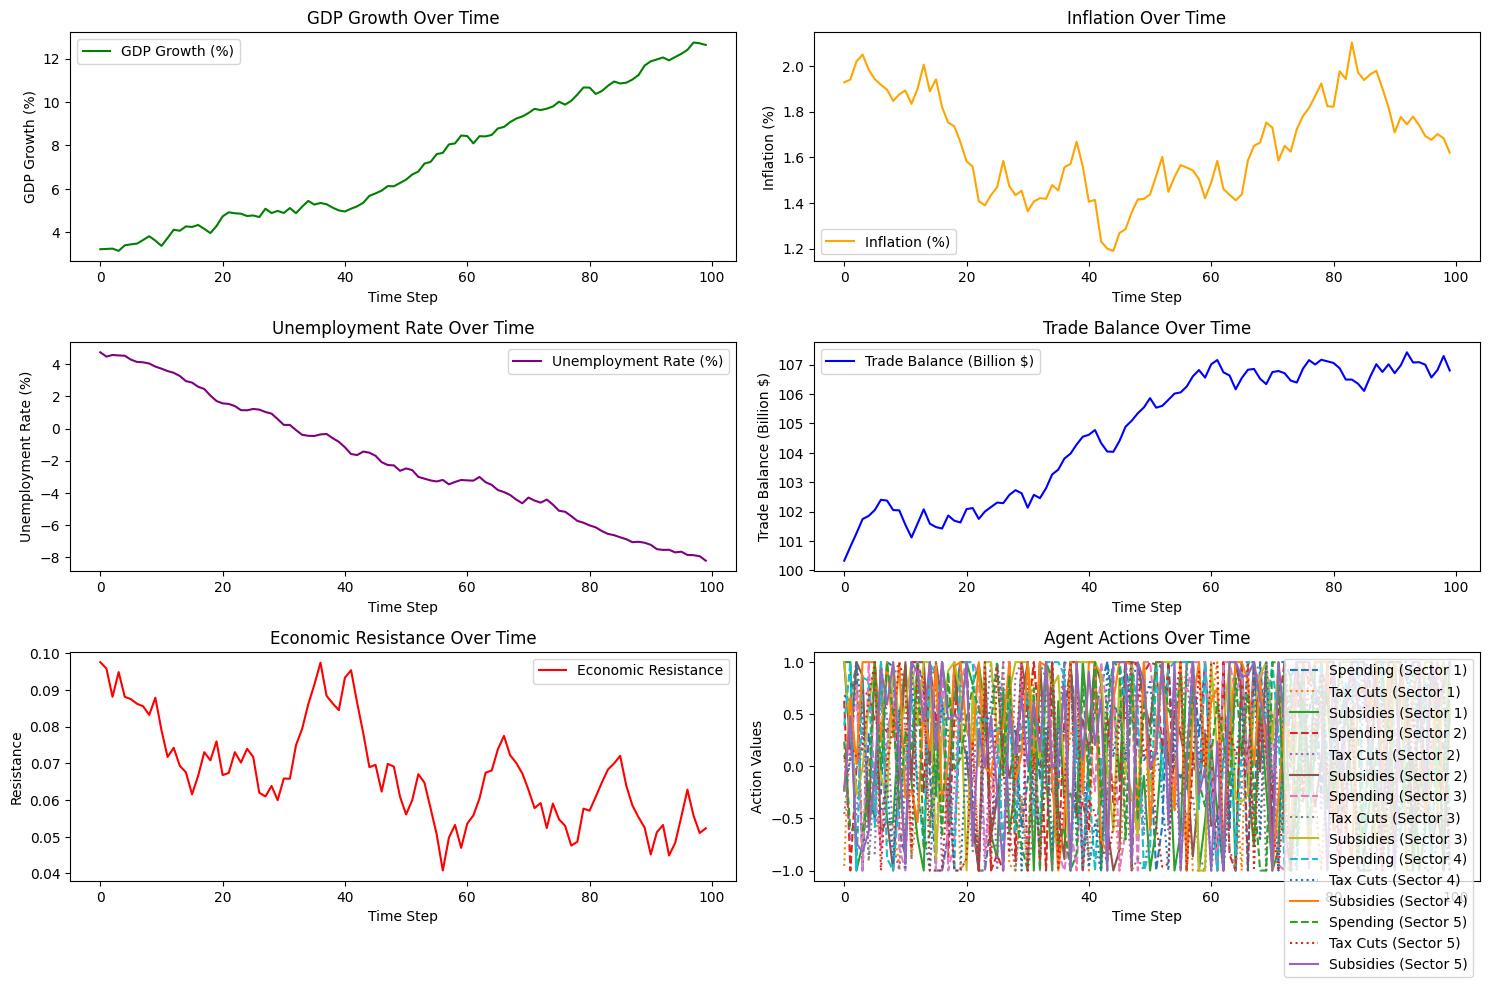

In [ ]:
!pip install stable-baselines3
!pip install shimmy
!pip install gymnasium
# Install required packages if not already installed
!pip install stable-baselines3 gymnasium matplotlib numpy

# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import gym

# Define the Custom Environment for Tensor-Based Economic Simulation
class MoneyAsTensorEnv(gym.Env):
    def __init__(self):
        super(MoneyAsTensorEnv, self).__init__()

        # Dimensions: Sectors, Agents
        self.sectors = 5
        self.agents = 3
        self.state = np.random.rand(self.sectors, self.agents)  # Money tensor initialization
        self.time_step = 0

        # Observation Space (Flattened Money Tensor)
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(self.sectors * self.agents,), dtype=np.float32)

        # Action Space: Spending, Tax Cuts, Subsidies for each sector
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(self.sectors, 3), dtype=np.float32)

        # Initialize economic indicators
        self.gdp = 3.0  # GDP Growth (%)
        self.inflation = 2.0  # Inflation (%)
        self.unemployment = 5.0  # Unemployment Rate (%)
        self.trade_balance = 100.0  # Trade Balance (Billion $)
        self.resistance = 0.1  # Economic Resistance

    def reset(self):
        # Reset environment to initial state
        self.state = np.random.rand(self.sectors, self.agents)
        self.gdp = 3.0
        self.inflation = 2.0
        self.unemployment = 5.0
        self.trade_balance = 100.0
        self.resistance = 0.1
        self.time_step = 0
        return self.state.flatten()

    def step(self, action):
        # Update the money tensor
        delta = action * 0.01  # Action impact scaled
        self.state += delta

        # Update economic indicators based on actions
        self.gdp += np.sum(action[:, 0]) * 0.1
        self.inflation += np.sum(action[:, 1]) * 0.05
        self.unemployment -= np.sum(action[:, 2]) * 0.1
        self.trade_balance += np.random.uniform(-1, 1) * 0.5  # Random fluctuation
        self.resistance += np.random.uniform(-0.01, 0.01)

        # Flatten the tensor for the RL agent
        observation = self.state.flatten()

        # Calculate reward
        reward = (
            self.gdp - abs(self.inflation - 2.0) - self.unemployment - abs(self.trade_balance - 100.0) * 0.01
        )

        # Increment time step
        self.time_step += 1
        done = self.time_step >= 100  # Episode ends after 100 time steps

        return observation, reward, done, {}

    def render(self, mode="human"):
        print(f"Time Step: {self.time_step}")
        print(f"GDP Growth: {self.gdp:.2f}%")
        print(f"Inflation: {self.inflation:.2f}%")
        print(f"Unemployment Rate: {self.unemployment:.2f}%")
        print(f"Trade Balance: ${self.trade_balance:.2f} Billion")
        print(f"Economic Resistance: {self.resistance:.2f}")
        print(f"Money Tensor State:\n{self.state}")

# Create and vectorize the environment
env = make_vec_env(lambda: MoneyAsTensorEnv(), n_envs=1)

# Initialize the PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Train the PPO model
print("Training the PPO agent...")
model.learn(total_timesteps=50000)
print("Training complete!")

# Save the model
model.save("ppo_money_tensor")

# Load the trained model
model = PPO.load("ppo_money_tensor")

# Evaluate the trained model
env = MoneyAsTensorEnv()
state = env.reset()

# Store results for visualization
gdp_values = []
inflation_values = []
unemployment_values = []
trade_balance_values = []
resistance_values = []
actions = []

for _ in range(100):
    # Predict the action using the trained model
    action, _ = model.predict(state)
    state, reward, done, _ = env.step(action)

    # Record economic indicators
    gdp_values.append(env.gdp)
    inflation_values.append(env.inflation)
    unemployment_values.append(env.unemployment)
    trade_balance_values.append(env.trade_balance)
    resistance_values.append(env.resistance)
    actions.append(action)

    if done:
        break

# Plot the results
time_steps = range(len(gdp_values))

plt.figure(figsize=(15, 10))

# GDP Growth
plt.subplot(3, 2, 1)
plt.plot(time_steps, gdp_values, label="GDP Growth (%)", color="green")
plt.title("GDP Growth Over Time")
plt.xlabel("Time Step")
plt.ylabel("GDP Growth (%)")
plt.legend()

# Inflation
plt.subplot(3, 2, 2)
plt.plot(time_steps, inflation_values, label="Inflation (%)", color="orange")
plt.title("Inflation Over Time")
plt.xlabel("Time Step")
plt.ylabel("Inflation (%)")
plt.legend()

# Unemployment
plt.subplot(3, 2, 3)
plt.plot(time_steps, unemployment_values, label="Unemployment Rate (%)", color="purple")
plt.title("Unemployment Rate Over Time")
plt.xlabel("Time Step")
plt.ylabel("Unemployment Rate (%)")
plt.legend()

# Trade Balance
plt.subplot(3, 2, 4)
plt.plot(time_steps, trade_balance_values, label="Trade Balance (Billion $)", color="blue")
plt.title("Trade Balance Over Time")
plt.xlabel("Time Step")
plt.ylabel("Trade Balance (Billion $)")
plt.legend()

# Resistance
plt.subplot(3, 2, 5)
plt.plot(time_steps, resistance_values, label="Economic Resistance", color="red")
plt.title("Economic Resistance Over Time")
plt.xlabel("Time Step")
plt.ylabel("Resistance")
plt.legend()

# Actions
plt.subplot(3, 2, 6)
actions = np.array(actions).reshape(-1, env.sectors, 3)  # Reshape actions for visualization
for i in range(env.sectors):
    plt.plot(time_steps, actions[:, i, 0], label=f"Spending (Sector {i+1})", linestyle="dashed")
    plt.plot(time_steps, actions[:, i, 1], label=f"Tax Cuts (Sector {i+1})", linestyle="dotted")
    plt.plot(time_steps, actions[:, i, 2], label=f"Subsidies (Sector {i+1})")
plt.title("Agent Actions Over Time")
plt.xlabel("Time Step")
plt.ylabel("Action Values")
plt.legend()

plt.tight_layout()
plt.show()
